<a href="https://colab.research.google.com/github/tumanov-a/home_bro/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import os
import splitfolders

from PIL import Image
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
!pip install split-folders

In [4]:
home_dir = '../content/drive/MyDrive/homebro'

for main_dir in os.listdir(home_dir):
        directory = os.path.join(home_dir, main_dir)
        for k, img_url in enumerate(os.listdir(directory)):
            img_url = os.path.join(directory, img_url)
            if k > 869:
                os.remove(img_url)

In [5]:
image_labels = os.listdir(home_dir)

In [6]:
splitfolders.ratio(home_dir, output='/content/sample_data', seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 4345 files [1:47:30,  1.48s/ files]


In [7]:
dirs = os.listdir('/content/sample_data/')
shapes = dict()
for dir in dirs:
  dir_1 = os.path.join('/content/sample_data/', dir)
  len_path = 0
  if os.path.isdir(dir_1):
    for dir_2 in os.listdir(dir_1):
      len_path += len(os.listdir(os.path.join(dir_1, dir_2)))
    shapes[dir] = len_path

In [8]:
train_size = shapes['train']
val_size = shapes['val']
test_size = shapes['test']

In [9]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    )

In [10]:
train_dir = os.path.join('/content/sample_data/', 'train')
test_dir = os.path.join('/content/sample_data/', 'test')
val_dir = os.path.join('/content/sample_data/', 'val')

In [11]:
BATCH_SIZE = 32
INPUT_SIZE = 224

In [12]:
train_data_gen = image_gen.flow_from_directory(directory=train_dir, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=(INPUT_SIZE, INPUT_SIZE), 
                                               class_mode='categorical')

val_data_gen = image_gen.flow_from_directory(directory=val_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(directory=test_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical',
                                              shuffle=False)

Found 3040 images belonging to 5 classes.
Found 650 images belonging to 5 classes.
Found 655 images belonging to 5 classes.


In [16]:
classifier_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

feature_extractor = tf.keras.Sequential([
                                         hub.KerasLayer(classifier_url, input_shape=(INPUT_SIZE,INPUT_SIZE,3))
])

feature_extractor.trainable = False

model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [17]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_gen, 
    steps_per_epoch=ceil(train_size/BATCH_SIZE), 
    epochs=30, 
    validation_data=val_data_gen, 
    validation_steps=ceil(val_size/BATCH_SIZE),
    callbacks=[early_stopping]
    )

Epoch 1/30
95/95 [==============================] - 52s 545ms/step - loss: 0.2148 - accuracy: 0.9424 - val_loss: 0.0956 - val_accuracy: 0.9723
Epoch 2/30
95/95 [==============================] - 51s 535ms/step - loss: 0.0871 - accuracy: 0.9773 - val_loss: 0.0676 - val_accuracy: 0.9738
Epoch 3/30
95/95 [==============================] - 51s 540ms/step - loss: 0.0338 - accuracy: 0.9882 - val_loss: 0.0695 - val_accuracy: 0.9785
Epoch 4/30
95/95 [==============================] - 51s 540ms/step - loss: 0.0195 - accuracy: 0.9918 - val_loss: 0.0737 - val_accuracy: 0.9815
Epoch 5/30
95/95 [==============================] - 51s 537ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 0.0804 - val_accuracy: 0.9738
Epoch 6/30
95/95 [==============================] - 51s 537ms/step - loss: 0.0187 - accuracy: 0.9918 - val_loss: 0.0985 - val_accuracy: 0.9754
Epoch 7/30
95/95 [==============================] - 51s 533ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.1039 - val_accuracy: 0.9738

In [18]:
history = model.history

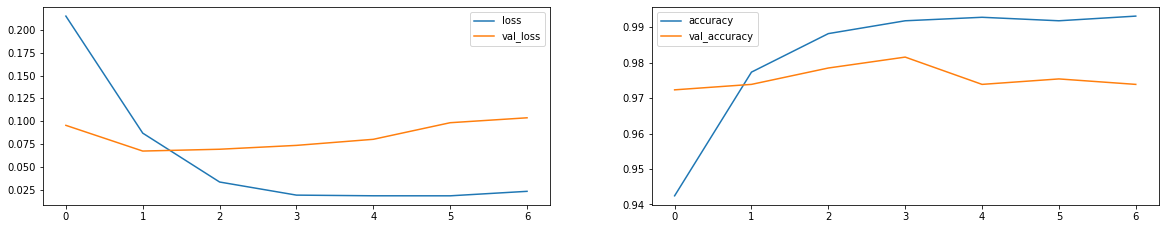

In [19]:
plt.figure(figsize=(20,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=ceil(test_size/BATCH_SIZE))

21/21 [==============================] - 9s 417ms/step - loss: 0.0909 - accuracy: 0.9756


In [21]:
test_labels = test_data_gen.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [106]:
predict_prob = model.predict(test_data_gen)
predictions = predict_prob.argmax(axis=-1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [90]:
print(classification_report(test_labels, predictions, target_names=image_labels))

              precision    recall  f1-score   support

   buildings       0.98      0.99      0.98       131
    entrance       0.96      0.99      0.97       131
  flat_plans       1.00      1.00      1.00       131
    interior       0.99      0.92      0.95       131
     windows       0.96      0.98      0.97       131

    accuracy                           0.98       655
   macro avg       0.98      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



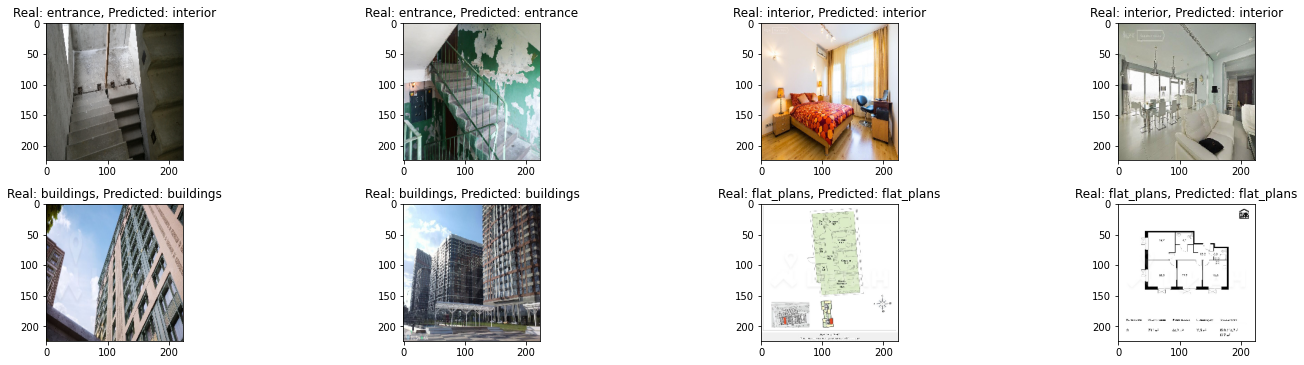

In [111]:
plt.figure(figsize=(20,20))


for i in range(8):

    index_batch = random.randint(0, 15)
    index_img = random.randint(0, 15)

    index_label_real = test_data_gen[index_batch][1][index_img].argmax(axis=0)
    img = test_data_gen[index_batch][0][index_img]

    plt.subplot(8, 4, i+1)
    plt.imshow(img)
    index_predicted_label = predictions[BATCH_SIZE * (index_batch + 1) + index_img]

    plt.title('Real: {}, Predicted: {}'.format(list(image_labels)[index_label_real], list(image_labels)[index_predicted_label]))

plt.tight_layout()

In [27]:
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
